In [68]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

#Replace each character in the string using the given translation table
from helper_code import *
str.translate?

print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


In [69]:
#Data Exploration and Visualization

#reading data in from files linewise
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

data_raw = dict()

import io
fi1 = io.open(r'C:\Users\Lenovo\Desktop\language\train_sentences_cs.cs',mode="r", encoding="utf-8")
data_raw['cs']= fi1.readlines()

fi2 = io.open(r'C:\Users\Lenovo\Desktop\language\train_sentences_sk.en', mode="r", encoding="utf-8")
data_raw['sk']= fi2.readlines()

fi3 = io.open(r'C:\Users\Lenovo\Desktop\language\train_sentences_en.en', mode="r", encoding="utf-8")
data_raw['en']= fi3.readlines()

In [70]:
#printing part of training set
print("---------------------------------------------1-------------------------------------------------------------")
print(data_raw['cs'][0:10])
print("---------------------------------------------2-------------------------------------------------------------")
print(data_raw['sk'][0:10])
print("---------------------------------------------3-------------------------------------------------------------")
print(data_raw['en'][0:10])

type(data_raw['en'])

---------------------------------------------1-------------------------------------------------------------
['Upozorňujeme, že jejím cílem je šetřit penězi za administrativní výdaje.\n', 'Zcela otevřeně přiznám, že ne vždy rozumím extrémně složitým vědeckým analýzám, které dostávám.\n', 'Při práci na této zprávě bylo třeba, abych pracovala právě s touto "představivostí".\n', 'A nakonec, plně podporuji myšlenku sjednotit vědeckovýzkumný sektor v energetické oblasti, jakožto klíčový prvek dané dlouhodobé politiky.\n', 'To je vážná věc.\n', 'Z tohoto hlediska zcela souhlasím s připomínkami pana Verheugena.\n', 'Rozprava je ukončena.\n', 'Vzhledem k významu, které má stavebnictví pro evropské hospodářství, je nutné odstranit technické překážky bránící obchodu se stavebními výrobky v zájmu zlepšení jejich volného pohybu na vnitřním trhu.\n', 'V roce 2009 je to popáté, kdy byly z tohoto fondu uvolněny prostředky, přičemž byla využita celková částka 53 milionů EUR z plánované výše 500 milionů

list

In [71]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        sample_extract=sentences[0:2]
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        
        number_of_words=len(word_list)
        number_of_sentences= len(sentences)
        number_of_unique_words=len(set(word_list))
        sample_extract=  ' '.join(sentences[0].split()[0:10])
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')
        #print(len(sentence_list))

In [72]:
# the statistics of training data using above function
show_statistics(data_raw)


Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi za administrativní výdaje....

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2012
Number of unique words	:	 1321
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká je pridaná hodnota...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little bit....



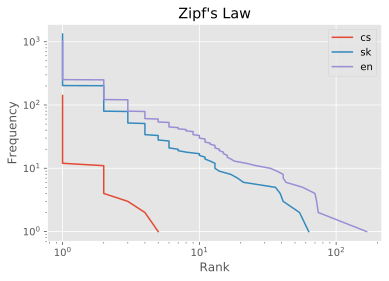

In [73]:
do_law_of_zipf(data_raw)

In [74]:
#Data Cleaning and Preprocessing

def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text


In [76]:
def split_into_subwords_function(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            if subword in word:
                word = word.replace(subword, ' ')
                subwords.append(subword)
    return ' '.join(subwords)

##########################################################################

def preprocess_function(text):
    '''
    removes punctuation from a string, and converts all characters to lowercase
    
    '''
    punctuation_without_hyphen = ''.join([x for x in string.punctuation if x != '-'])
    translation_table = str.maketrans('\n-', '  ', punctuation_without_hyphen+string.digits)
    return text.translate(translation_table).lower()

In [77]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}
print(len(data_preprocessed))
print(len(data_preprocessed['cs']))
print(len(data_preprocessed['sk']))
print(len(data_preprocessed['en']))

3
10
100
100


In [78]:
show_statistics(data_preprocessed)

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi za administrativní výdaje...

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1992
Number of unique words	:	 1205
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká je pridaná hodnota...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2366
Number of unique words	:	 904
Sample extract		:	 i can understand your approach a little bit...



In [79]:
#The Naive Bayes Model
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [80]:
vectorizer = CountVectorizer()

print(len(sentences_train))
sentences_train[0:3]

210


['upozorňujeme že jejím cílem je šetřit penězi za administrativní výdaje ',
 'zcela otevřeně přiznám že ne vždy rozumím extrémně složitým vědeckým analýzám které dostávám ',
 'při práci na této zprávě bylo třeba abych pracovala právě s touto představivostí ']

In [81]:
X_train = vectorizer.fit_transform(sentences_train)

print("shape",(X_train).shape)
print("----------------------")
print((X_train[0]))  #countvectorizer prints 1 at all the points count_word>1

shape (210, 2206)
----------------------
  (0, 1855)	1
  (0, 2194)	1
  (0, 681)	1
  (0, 298)	1
  (0, 672)	1
  (0, 2183)	1
  (0, 1135)	1
  (0, 2058)	1
  (0, 21)	1
  (0, 1979)	1


In [82]:
#Initializing Model Parameters and Training
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [85]:
#Vectorizing Validation Data and Evaluating Model
data_val = dict()

import io
f1 = io.open(r'C:\Users\Lenovo\Desktop\language\val_sentences_cs.cs', encoding="utf-8")
data_val['cs']= f1.readlines()

f2 = io.open(r'C:\Users\Lenovo\Desktop\language\val_sentences_sk.sk', mode="r", encoding="utf-8")
data_val['sk']= f2.readlines()

f3 = io.open(r'C:\Users\Lenovo\Desktop\language\val_sentences_en.en', mode="r", encoding="utf-8")
data_val['en']= f3.readlines()


data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [86]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)
        

In [87]:
X_val = vectorizer.transform(sentences_val)
print(X_val.shape)

predictions = naive_classifier.predict(X_val)
print(len(predictions))



(15000, 2206)
15000


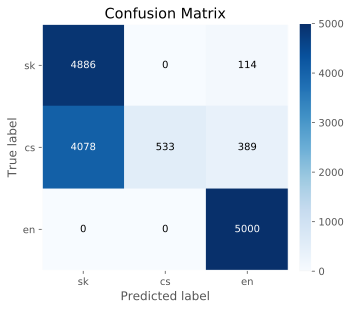

In [88]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [89]:
f1_score(y_val, predictions, average='weighted')

0.6148568714052669

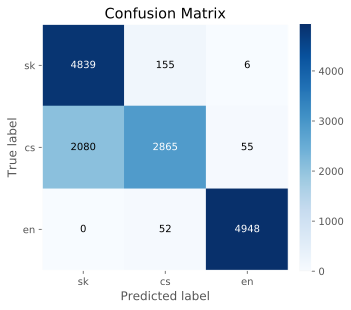

In [90]:
#Simple Adjustments 
naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [91]:
f1_score(y_val, predictions, average='weighted')

0.8368507601649364

In [93]:
#using Subwords to minimise class imbalance
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [94]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

############################
vocab = get_vocab(sentences_train)

In [96]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [97]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v
            
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [98]:
def split_into_subwords(text):
    merges =merge_ordered #codecs.open(r'C:\Users\Lenovo\Desktop\language\merge_ordered.pkl', 'rb', 'utf-8')
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

###########################################
split_into_subwords('this is ari here')


'is th is ar re'

In [99]:
###########################################
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}
show_statistics(data_preprocessed_subwords)
#number of unique words are comparable now

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 288
Number of unique words	:	 85
Sample extract		:	 po me or je že je ím le je it...

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3937
Number of unique words	:	 118
Sample extract		:	 de an de al as ne as ve li vy...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 4242
Number of unique words	:	 104
Sample extract		:	 an st an er un ou ro ch it le...



In [100]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))
    
vectorizer = CountVectorizer()    

In [101]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

naive_classifier = MultinomialNB(alpha=1, fit_prior=False)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=False)

0.8500233831910026

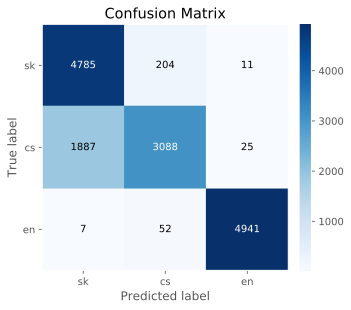

In [102]:
predictions = naive_classifier.predict(X_val)
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])
f1_score(y_val, predictions, average='weighted')